In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from helpers.dataloader import *
import pickle
import os
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score

In [2]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
torch.cuda.device_count()

2

In [3]:
root_dir = '/scratch/bva212/breastCancerData'
image_column = 'image file path'
batchSize =16
num_classes = 2
image_resize =1024

train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([image_resize,image_resize]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([image_resize,image_resize]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# randomTrainSet, randomValidationSet randomTestSet
train_data = CBISDDSMDataset('Train.pkl', root_dir, image_column, num_classes = num_classes, num_channel=3, transform = train_transform, transform_type = None, transform_prob=0.5)
val_data = CBISDDSMDataset('Val.pkl', root_dir, image_column, num_classes = num_classes, num_channel=3, transform = validation_transform, transform_type = None, transform_prob=0.5)
test_data = CBISDDSMDataset('Test.pkl', root_dir, image_column, num_classes = num_classes, num_channel=3, transform = validation_transform, transform_type = None, transform_prob=0.5)

image_datasets = {'train': train_data, 'val': val_data, 'test': test_data}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batchSize, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

/home/bva212/dl4medProject/helpers/dataloader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.data_frame['label'][self.data_frame['label'] == 2] = 0
/home/bva212/dl4medProject/helpers/dataloader.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.data_frame['label'][self.data_frame['label'] == 3] = 1


In [4]:
resnet34 = models.resnet34(pretrained=False)

In [5]:
fc_in_features = resnet34.fc.in_features
resnet34.fc = torch.nn.Linear(fc_in_features, num_classes)

In [9]:
PATH = '/scratch/bva212/dl4medProject/nhung_models/resNet34_tl.pt'
#resnet34Parallel
resnet34 = torch.load(PATH)

In [10]:
resnet34.to(device)
resnet34Parallel = torch.nn.DataParallel(resnet34)

In [11]:
def evaluate_model(model, dataloader, loss_fn, phase = 'test'):
    model.eval()
    running_correct = 0
    running_loss = 0
    running_total = 0
    outputs = np.array(0)
    preds = np.array(0)
    labels = np.array(0)
    for data in dataloader[phase]:
        inputs = data['x'].type(torch.FloatTensor).to(device)
        label = data['y'].to(device)
        output = model(inputs)
        loss = loss_fn(output, label)
        _, pred = torch.max(output, dim = 1)
        num_inputs = inputs.size()[0]
        output = F.softmax(output)
        outputs = np.append(outputs, output.cpu().detach().numpy())
        preds = np.append(preds, pred.cpu().detach().numpy())
        labels = np.append(labels, label.cpu().detach().numpy())
        running_correct += torch.sum(pred ==label).item()
        running_loss += loss.item()*num_inputs
        running_total += num_inputs
    accuracy = float(running_correct/running_total)
    loss = float(running_loss/running_total)
    
    return outputs[1:], preds[1:], labels[1:], accuracy, loss

In [12]:
criterion = nn.CrossEntropyLoss()
outputs, preds, labels, accuracy, loss = evaluate_model(resnet34Parallel, dataloaders, criterion, phase = 'test')

/home/bva212/dl4med/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


In [13]:
print('Accuracy is: {}'.format(accuracy))
print('Loss is: {}'.format(loss))

Accuracy is: 0.65
Loss is: 0.6483241327603658


In [14]:
def inference(model_ft,loader):
    use_gpu = 1
    model_ft.eval()
    whole_output =[]
    whole_target = []

    for valData in loader:
        data = valData['x']
        target = valData['y']
        if use_gpu:
            data = data.type(torch.FloatTensor).cuda()
            target = target.type(torch.LongTensor).cuda()
        else:
            data, target = data.type(torch.FloatTensor), target.type(torch.LongTensor)

        output =F.softmax(model_ft(data),dim=1)
        whole_output.append( output.cpu().data.numpy())
        whole_target.append( valData['y'].numpy())

    whole_output = np.concatenate(whole_output)
    whole_target = np.concatenate(whole_target)

    y_score = whole_output
    y_target = label_binarize(whole_target, classes=[0, 1])
    
    return y_score, y_target

# this function AUC of ROC for binary classification problem. 
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

def get_AUC(y_score, y_target,plotROC=False):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_target, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
  
    if plotROC:
        lw = 2
        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr, tpr, lw=lw,
                 label='ROC curve (area = %.6s)'%str(roc_auc))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) curve')
        plt.legend(loc="lower right")
        plt.show()

    return roc_auc

# confusion matrix function
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



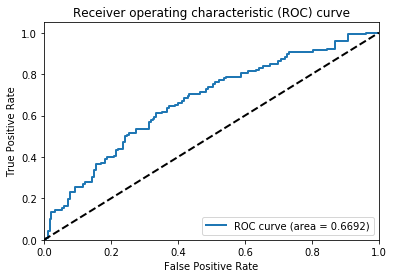

AUC:  0.6692121437884151
Confusion matrix, without normalization


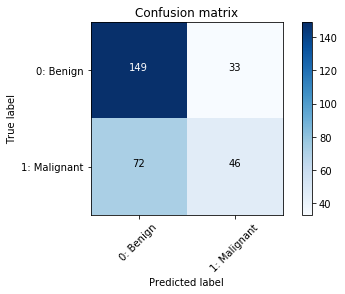

In [15]:
y_s, y_t=inference(resnet34Parallel, dataloaders['test'])
r_AUC_wholeSet = get_AUC(y_s, y_t,True)
print('AUC: ', r_AUC_wholeSet)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t, np.argmax(y_s,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['0: Benign','1: Malignant']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

In [16]:
resnet18 = models.resnet18(pretrained=False)

In [17]:
fc_in_features = resnet18.fc.in_features
resnet18.fc = torch.nn.Linear(fc_in_features, num_classes)

In [18]:
PATH = '/scratch/bva212/dl4medProject/nhung_models/resNet18_tl.pt'
#resnet34Parallel
resnet18 = torch.load(PATH)

In [19]:
resnet18.to(device)
resnet18Parallel = torch.nn.DataParallel(resnet18)

In [20]:
criterion = nn.CrossEntropyLoss()
outputs, preds, labels, accuracy, loss = evaluate_model(resnet34Parallel, dataloaders, criterion, phase = 'test')

/home/bva212/dl4med/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


In [21]:
print('Accuracy is: {}'.format(accuracy))
print('Loss is: {}'.format(loss))

Accuracy is: 0.65
Loss is: 0.648324134349823


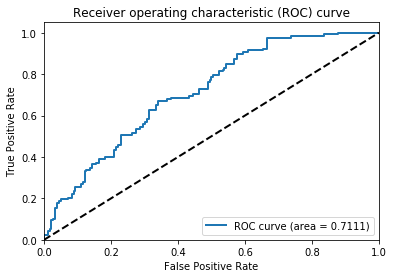

AUC:  0.7111659526913765
Confusion matrix, without normalization


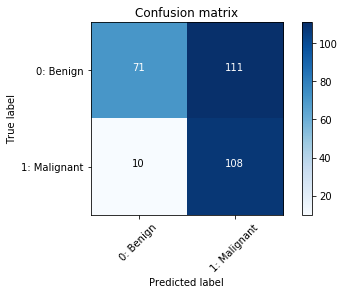

In [22]:
y_s, y_t=inference(resnet18Parallel, dataloaders['test'])
r_AUC_wholeSet = get_AUC(y_s, y_t,True)
print('AUC: ', r_AUC_wholeSet)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t, np.argmax(y_s,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['0: Benign','1: Malignant']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')